# Recidivism in Georgia

In [ ]:
# Importing packages
import re
import shap
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, norm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import resample

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate


## Dataset analysis

In [3]:
# Loading the dataset
df = pd.read_csv('exam_data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')

# Renaming columns
df = df.rename(columns={
    'Prior_Conviction_Episodes_Felony': 'Prior_Conviction_Felony',
    'Prior_Conviction_Episodes_Misd': 'Prior_Conviction_Misd',
    'Prior_Conviction_Episodes_Viol': 'Prior_Conviction_Viol',
    'Prior_Conviction_Episodes_Prop': 'Prior_Conviction_Prop',
    'Prior_Conviction_Episodes_Drug': 'Prior_Conviction_Drug',
    'Prior_Conviction_Episodes_PPViolationCharges': 'Prior_Conviction_PPViolation',
    'Prior_Conviction_Episodes_DomesticViolenceCharges': 'Prior_Conviction_DVCharges',
    'Prior_Conviction_Episodes_GunCharges': 'Prior_Conviction_GunCharges'
    
    })

# Target is whether or not they reoffend
target=df['Recidivism_Within_3years']

# Protected features
grouprace=df['Race']
groupsex=df['Gender']

# Split immedeatly to avoid leaking from dataset
# First split: temporary and test set
X_train, X_test, y_train, y_test, grouprace_train, grouprace_test, groupsex_train, groupsex_test = train_test_split(
    df, target, grouprace, groupsex, test_size=0.2, random_state=22)


## Demographic of offenders

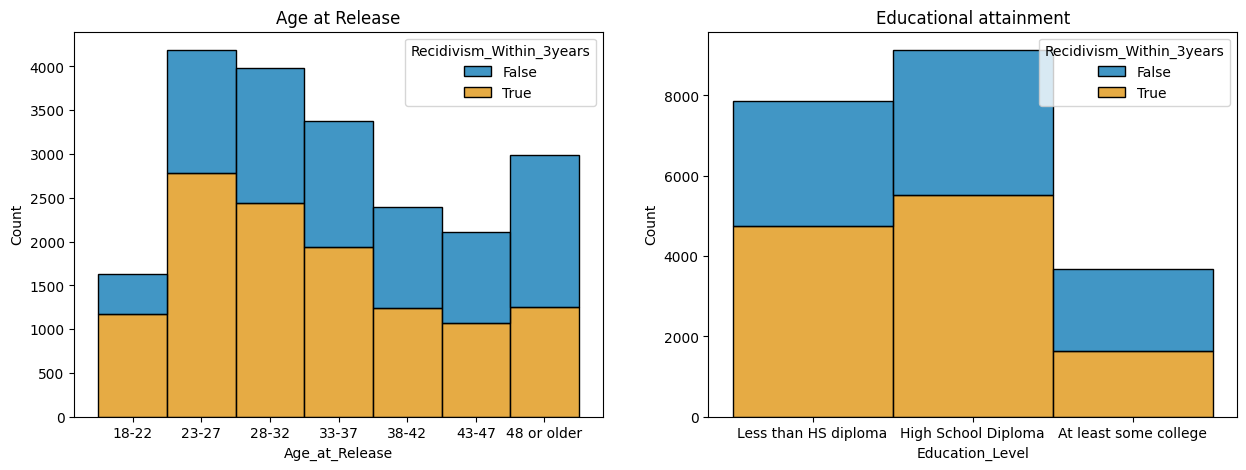

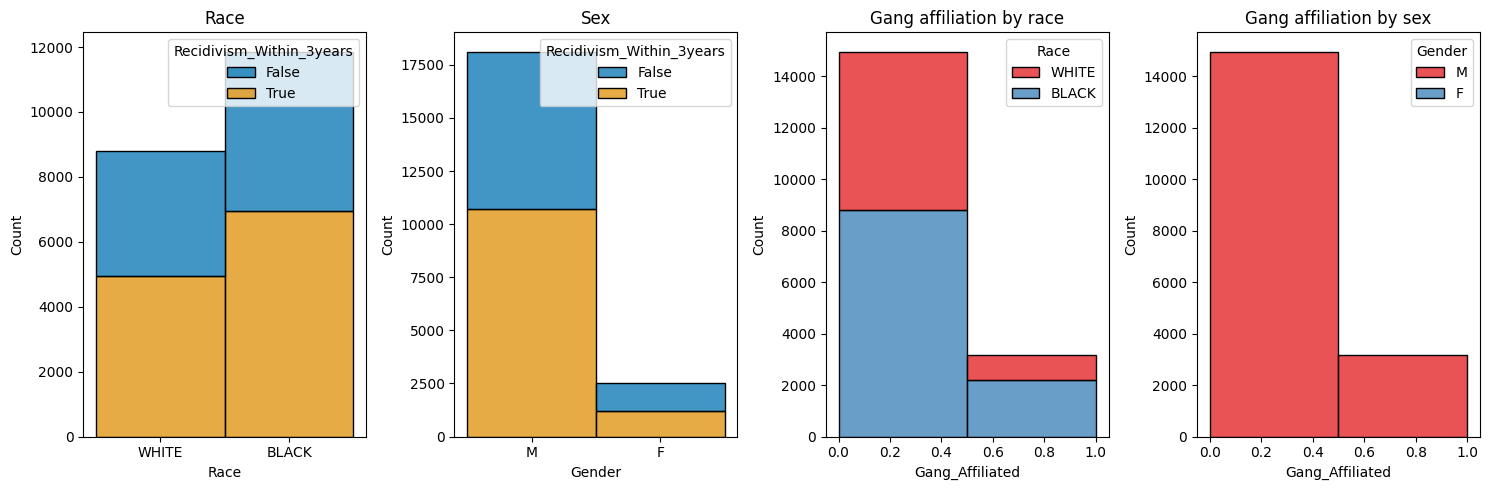

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

sns.histplot(x='Age_at_Release', data=X_train.sort_values(by='Age_at_Release'), hue='Recidivism_Within_3years', bins=5, ax=axes[0], multiple='stack',palette='colorblind')
axes[0].set_title('Age at Release')

X_train['Education_Level'] = pd.Categorical(X_train['Education_Level'], ['Less than HS diploma', 'High School Diploma', 'At least some college'])
sns.histplot(data=X_train, x='Education_Level', bins=3, ax=axes[1], hue='Recidivism_Within_3years', multiple='stack',palette='colorblind')
axes[1].set_title('Educational attainment')

fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Recidivism

sns.histplot(x='Race', data=X_train, ax=axes[0], bins=2, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[0].set_title('Race')

sns.histplot(x='Gender', data=X_train, ax=axes[1], bins=2, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[1].set_title('Sex')
sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[2], bins=2, palette='Set1', hue='Race', multiple='stack')
axes[2].set_title('Gang affiliation by race')


sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[3], bins=2, palette='Set1', hue='Gender', multiple='stack')
axes[3].set_title('Gang affiliation by sex')
# The Gang affiliation values for females are NaN!

plt.tight_layout()

In [5]:
# Chekcing for missing female gang affiliation values
print(X_train.groupby(['Gender', 'Gang_Affiliated']).size())
print(X_train.groupby(['Gender']).size())

Gender  Gang_Affiliated
M       False              14961
        True                3164
dtype: int64
Gender
F     2543
M    18125
dtype: int64


## Age, group and type of offense

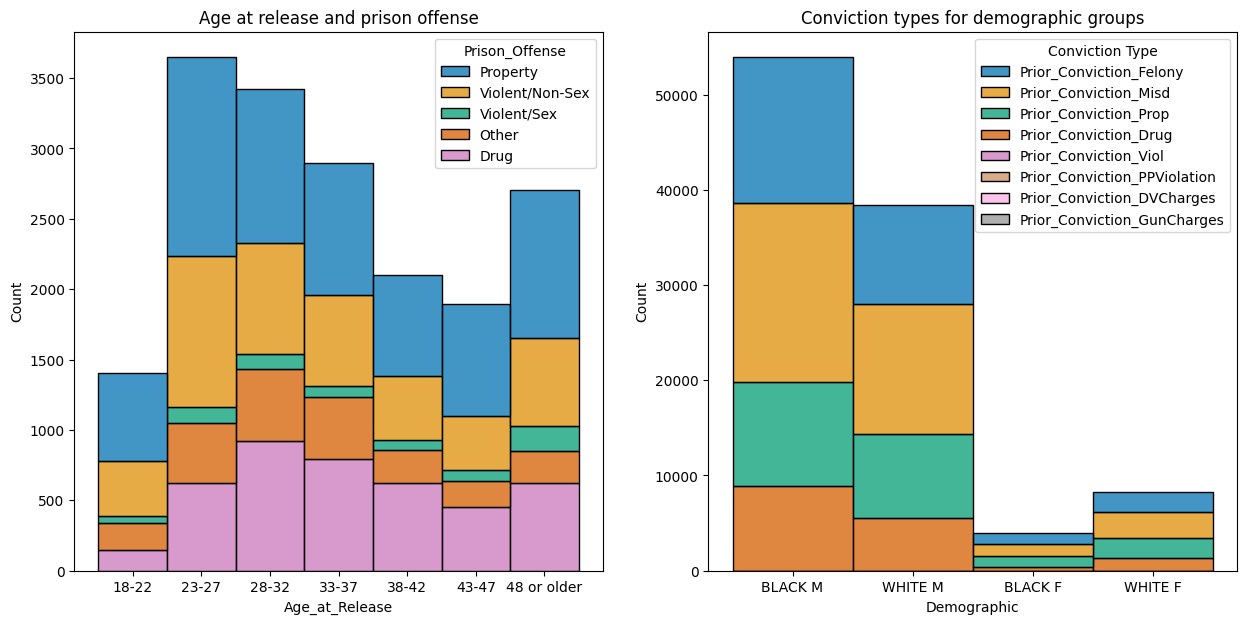

In [6]:
# Combine Race and Gender into single label
X_train['Demographic'] = X_train['Race'].astype(str) + ' ' + X_train['Gender'].astype(str)

# Conviction columns
conviction_cols = [
    'Prior_Conviction_Felony',
    'Prior_Conviction_Misd',
    'Prior_Conviction_Prop',
    'Prior_Conviction_Drug',
    'Prior_Conviction_Viol',
    'Prior_Conviction_PPViolation',
    'Prior_Conviction_DVCharges',
    'Prior_Conviction_GunCharges'
]

# Melt DataFrame
df_convictions = X_train[conviction_cols + ['Demographic']].copy()
df_melted = df_convictions.melt(
    id_vars='Demographic',
    value_vars=conviction_cols,
    var_name='Conviction Type',
    value_name='Count'
)

# Convert string values like '3 or more' to integer
df_melted['Count'] = df_melted['Count'].apply(
    lambda x: int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0
)

# Set demographic order 
demographic_order = ['BLACK M', 'WHITE M', 'BLACK F', 'WHITE F']
df_melted['Demographic'] = pd.Categorical(df_melted['Demographic'], categories=demographic_order, ordered=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Age at Release
sns.histplot(x='Age_at_Release', data=X_train.sort_values(by='Age_at_Release'), hue='Prison_Offense', bins=5, ax=axes[0], multiple='stack', palette='colorblind')
axes[0].set_title('Age at release and prison offense')

# Convictions stacked by type per demographic group
sns.histplot(data=df_melted, x='Demographic', weights='Count', hue='Conviction Type', multiple='stack', ax=axes[1], palette='colorblind'
             )
axes[1].set_title('Conviction types for demographic groups')
axes[1].tick_params(axis='x')

# Dropping the temporary demographic column
X_train=X_train.drop(['Demographic'],axis=1)


## Risk score and recidivism

Short investigation of Risk score, we won't be fitting it in our model, but this gives us an idea of the feature.

Text(0.5, 1.0, 'Risk score and type of offense')

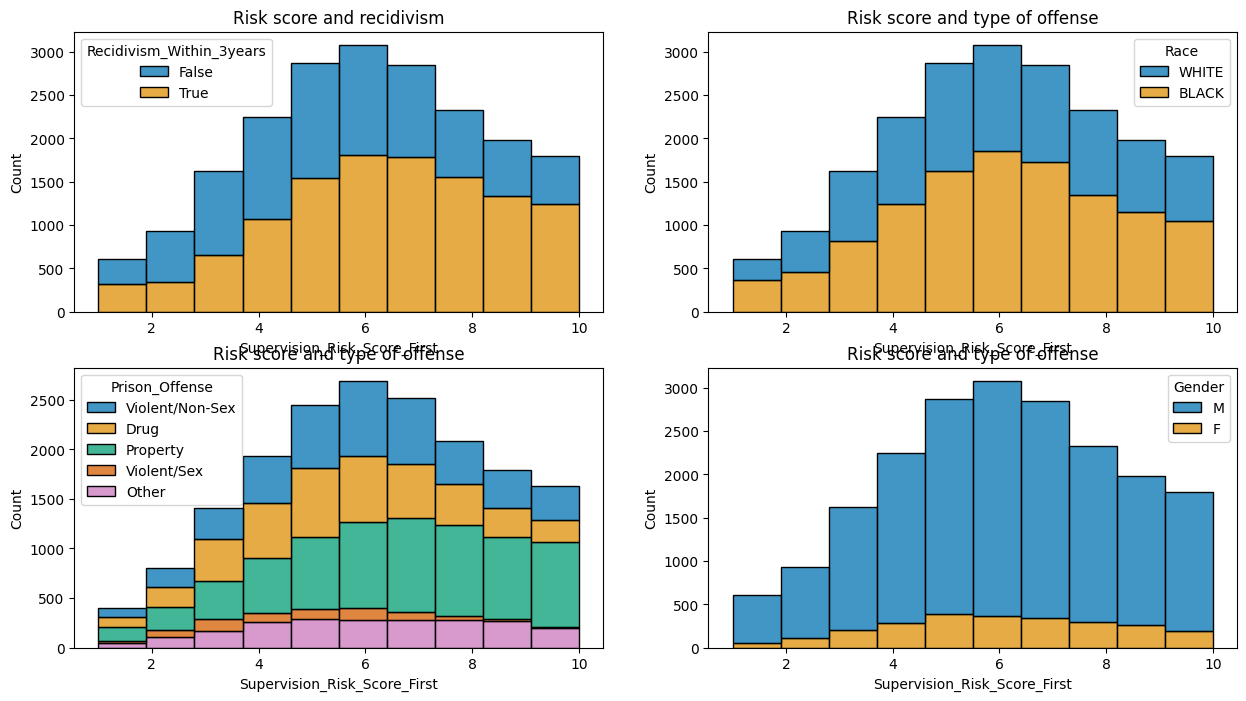

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))  

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,0], bins=10, palette='colorblind', hue='Recidivism_Within_3years', multiple='stack')
axes[0,0].set_title('Risk score and recidivism')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,0], bins=10, palette='colorblind', hue='Prison_Offense', multiple='stack')
axes[1,0].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0,1], bins=10, palette='colorblind', hue='Race', multiple='stack')
axes[0,1].set_title('Risk score and type of offense')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1,1], bins=10, palette='colorblind', hue='Gender', multiple='stack')
axes[1,1].set_title('Risk score and type of offense')

We will be dropping supervision risk score as a feature, since it is based on another classification model and we are unable to investigate what goes in to the given supervision risk score. Therefore we cannot guarantee that it is unbiased.

## Preprocessing
### Dropping and grouping columns

In [ ]:
def preprocess_data(df):
    df_processed = df.copy()
    # Grouping drug data
    df_processed['DrugTest_Positive']=df_processed[['DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive']].any(axis=1)

    # Changing age scale categories to numerical data
    df_processed['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
    df_processed['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
    df_processed['Education_Level']=df['Education_Level'].replace(['Less than HS diploma','High School Diploma', 'At least some college'], [1,2,3])
    df_processed['Prison_Years']=df['Prison_Years'].replace(['Less than 1 year','1-2 years','Greater than 2 to 3 years','More than 3 years'],[1,2,3,4])

    # Representing the groups as binary, and renaming gender to sex (since the correct class in this case is sex)
    df_processed['Race']=df['Race'].replace(['WHITE','BLACK'],[1,0])
    df_processed['Sex']=df['Gender'].replace(['M','F'],[1,0])

    
    ## Handling NaN values
    # Assuming no information of gang affiliation equals no gang affiliation
    df_processed['Gang_Affiliated']=df['Gang_Affiliated'].fillna(0).astype(int)

    # Assuming no information for days per drug test means rare/never test (could potentially be better modelled categorical)
    df_processed['Avg_Days_per_DrugTest']=df['Avg_Days_per_DrugTest'].fillna(365*3).astype(int) 

    # Assuming no data on jobs does not necessarily mean unemployment, therefore filling NaN with mean value 
    df_processed['Percent_Days_Employed']=df['Percent_Days_Employed'].fillna(df['Percent_Days_Employed'].mean()).astype(int)
    df_processed['Jobs_Per_Year']=df['Jobs_Per_Year'].fillna(df['Jobs_Per_Year'].mean()).astype(int)

    ## Dropping columns 
    # Assume arrest data is potentially biased (dependent on the police officer) and arrest \neq convicted
    # No knowledge on how supervision risk score/level is generated, (not clear which algorithm is used to generate it)
    df_processed=df_processed.drop(['Gender','ID','Residence_PUMA','Prior_Arrest_Episodes_Felony',
        'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
        'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
        'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Arrest_Episodes_DVCharges', 
        'Prior_Arrest_Episodes_GunCharges','Program_UnexcusedAbsences','Prior_Revocations_Parole',
        'Prior_Revocations_Probation','DrugTests_THC_Positive',
        'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
        'DrugTests_Other_Positive','Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3',
         'Training_Sample', 'Recidivism_Within_3years', 'Supervision_Risk_Score_First', 'Supervision_Level_First'], axis=1)

    # Make string-numerical data numerical
    def extract_number(val):
        val_str = str(val) # ensure string
        match = re.search(r'\d+', val_str) # find value in string
        return int(match.group()) if match else pd.NA # return value

    # Features with string values converted
    ## (obs values like '3 or more' is thus converted to numerical value 3)
    cols = ['Dependents', 'Prior_Conviction_Felony', 'Prior_Conviction_Misd', 'Prior_Conviction_Prop',
        'Prior_Conviction_Drug','Delinquency_Reports', 'Program_Attendances', 'Residence_Changes']
    df_processed[cols] = df_processed[cols].applymap(extract_number).astype('Int64')

    # One hot encoding the boolean value prison offence 
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=['Prison_Offense'], drop_first=True)

    # Rearranging the dataframe to have protected features first
    first_columns = ['Sex', 'Race']
    remaining_columns = [col for col in df_processed.columns if col not in first_columns]
    df_processed = df_processed[first_columns + remaining_columns]

    return df_processed

# Avoid leakage by preprocessing seperately
X_train=preprocess_data(X_train)
X_test=preprocess_data(X_test)

features=X_train.columns

# Standardizing all features
scaler = StandardScaler().fit(X_train.astype(float))
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

## Correlations

We mostly have numerical scale data and only binary categorical data, therefore we choose to look at pearson correlations. We looked into cramer correlations but should not be necessary for the way we scaled our data

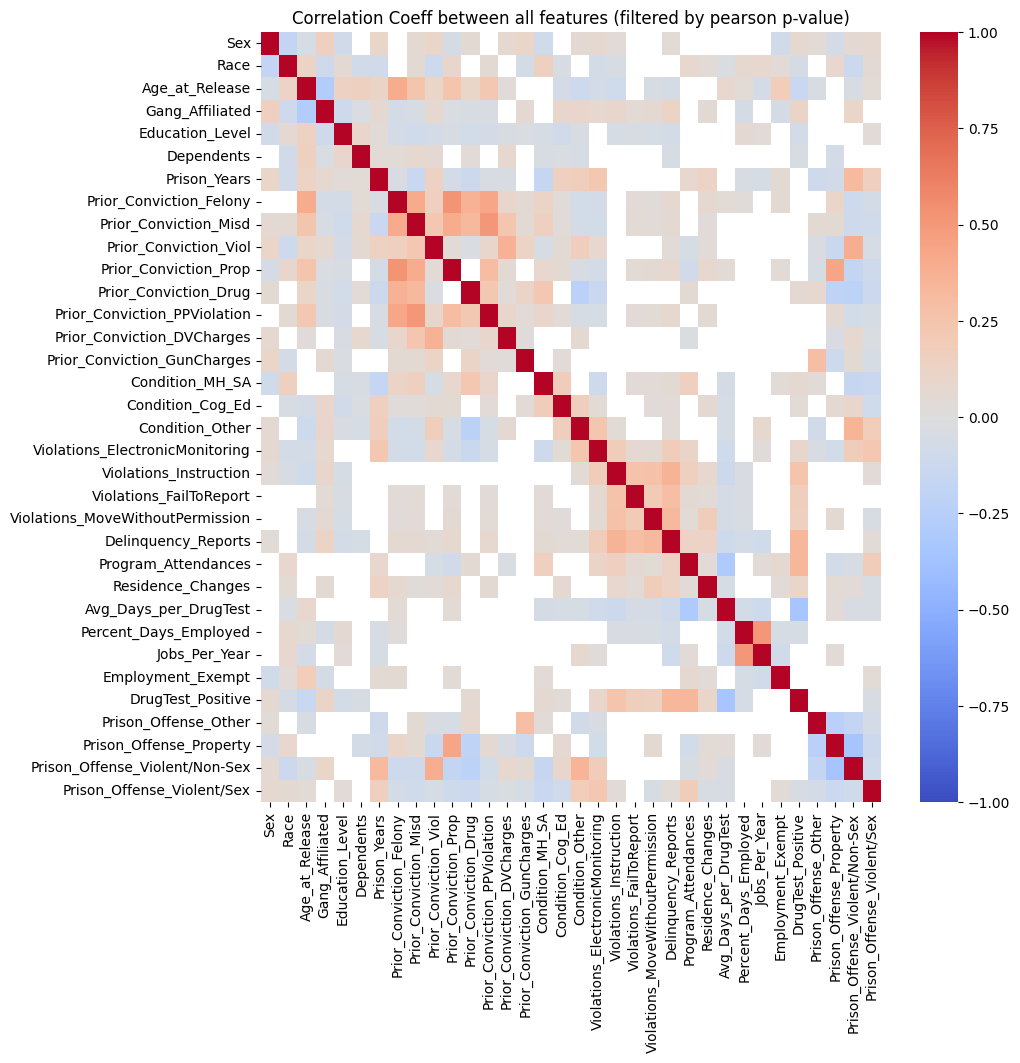

In [9]:
n_features = Xs_train.shape[1]
alpha = 0.05 # Significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# Compute p-value using pearson
corr_pearson = np.zeros((n_features, n_features))
p = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_pearson[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
        if np.isnan(corr_pearson[i,j]):
            p[i,j] = 1

plt.figure(figsize=(10,10))
sns.heatmap(corr_pearson, vmin=-1, vmax=1, cmap="coolwarm", xticklabels=features, yticklabels=features, mask= p > corrected_alpha) ## mask if p is higher
plt.title("Correlation Coeff between all features (filtered by pearson p-value)")
plt.show()

We see quite a lot significant correlation, however many of which are numerically very small.

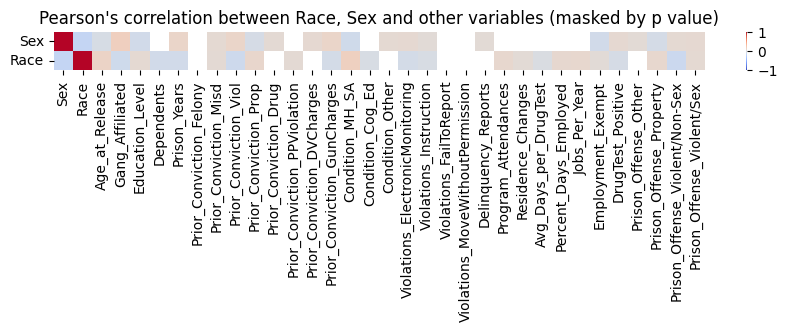

In [11]:
corr_pear = pd.DataFrame(corr_pearson, columns=features)
p_df = pd.DataFrame(p, columns=features, index=features)

plt.figure(figsize=(10.5,0.5))
sns.heatmap(corr_pear[['Sex','Race']].transpose(), vmin=-1,vmax=1, cmap="coolwarm",  yticklabels=['Sex','Race'], xticklabels=features,  mask = (p_df > corrected_alpha)[['Sex','Race']].transpose().values) #)  & (corr_pear_cramer > 0.005))[['Sex','Race']], vmin=-0.25, vmax=0.25)
plt.title("Pearson's correlation between Race, Sex and other variables (masked by p value)")
plt.show()

## Model fitting

In [ ]:
# Saving a training dataset without the protected features
Xs_train_none = np.delete(Xs_train, [0,1], axis=1)
Xs_test_none = np.delete(Xs_test, [0,1], axis=1)

Xs_train_protected = Xs_train[:, [0, 1]]
Xs_test_protected = Xs_test[:, [0, 1]]

y_train=y_train.values
y_test=y_test.values

## Finetuning hyper parameters

Takes approx 10 minutes to run

In [ ]:
## Logistic regression

# Xs_train is dense (scaled) -> therefore solver is lbfgs
# L2 for penalizing the SS of the weights 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_LR = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs'), param_grid, cv=5) #liblinear for binary 
grid_search_LR.fit(Xs_train_none, y_train)  

print("Best C:", grid_search_LR.best_params_['C'])
print("Best score:", grid_search_LR.best_score_)
C=grid_search_LR.best_params_['C']

## Random forest

rf = RandomForestClassifier(random_state=33, n_jobs=-1)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 5-fold CV grid search
grid_search_RF = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    #scoring='accuracy',   # or another metric like 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# Fit 
grid_search_RF.fit(Xs_train_none, y_train)

# Best combination
print("Best params:", grid_search_RF.best_params_)
print("Best CV score:", grid_search_RF.best_score_)


Best C: 0.001
Best score: 0.6806176021264883
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6857463574184491


In [14]:
group_test_dict = {
    'Male': groupsex_test == 'M',
    'Female': groupsex_test == 'F',
    'White': grouprace_test == 'WHITE',
    'Black':  grouprace_test == 'BLACK'
}

# Fit LR model
baselineLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
baselineLR.fit(Xs_train_none, y_train)

# Fit RF model
baselineRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

baselineRF.fit(Xs_train_none, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=33)

## Weights for the initial model

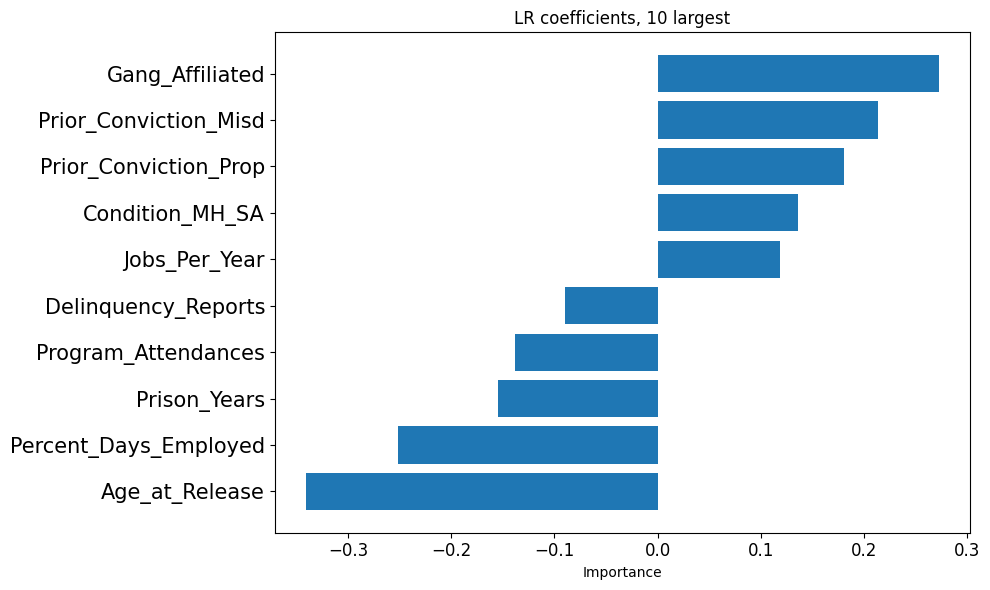

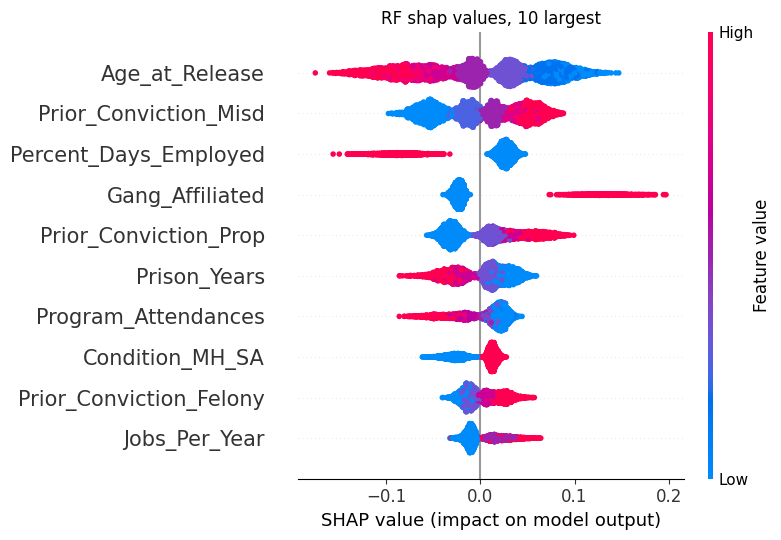

In [ ]:
## LR weights
coefficients = baselineLR.coef_[0]
feature_importance = pd.DataFrame({'Feature': features[2:], 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance_sorted = feature_importance.sort_values('Importance', ascending=True)

# Getting the top 10 largest
top_negative = feature_importance_sorted.head(5)
top_positive = feature_importance_sorted.tail(5)

# Combine and sort again 
top_features = pd.concat([top_negative, top_positive])
top_features = top_features.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.title('LR coefficients, 10 largest')
plt.xlabel('Importance')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


## RF shap values
explainer = shap.TreeExplainer(baselineRF, Xs_train_none, model_output='probability')
shap_values = explainer(Xs_test_none)

plt.figure(figsize=(10, 6))
# Summary plot, 10 most significant
shap.summary_plot(shap_values[:,:,1], Xs_test_none, 
                  feature_names=features[2:], 
                  max_display=10, show=False)

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title(f'RF shap values, 10 largest')
plt.tight_layout()
plt.show()


In [ ]:
# Initialize dictionaries to store results for each group and metric
results = {
    'model': [],  
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],
    'f1': []
}

# Bootstrapping
n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test_none[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': baselineLR.predict(X_bs),
        'RF': baselineRF.predict(X_bs)
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Reordering
desired_order = ['Black', 'White', 'Male', 'Female', 'Overall']
results_df['group'] = pd.Categorical(
    results_df['group'],
    categories=desired_order,
    ordered=True
)

# Summary by group and model
summary_by_group_model_baseline = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_baseline = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_baseline[(model, group)] = ci

Bootstrapping: 100%|██████████| 1000/1000 [02:33<00:00,  6.53it/s]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_29900\995295323.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_by_group_model_baseline = results_df.groupby(['model', 'group']).mean()


### Metrics for initial model fitting

In [47]:
summary_by_group_model_baseline

tp        fp        tn       fn       tpr       fpr  \
model group                                                                
LR    Black    1464.592   662.854   547.648  309.809  0.825395  0.547582   
      White    1015.241   447.305   496.133  223.418  0.819634  0.474130   
      Male     2270.871   947.486   842.504  482.104  0.824872  0.529325   
      Female    208.962   162.673   201.277   51.123  0.803420  0.446965   
      Overall  2479.833  1110.159  1043.781  533.227  0.823022  0.515408   
RF    Black    1473.112   643.080   567.422  301.289  0.830201  0.531249   
      White    1024.764   432.152   511.286  213.895  0.827323  0.458050   
      Male     2293.128   926.216   863.774  459.847  0.832958  0.517442   
      Female    204.748   149.016   214.934   55.337  0.787199  0.409424   
      Overall  2497.876  1075.232  1078.708  515.184  0.829011  0.499194   

               accuracy        f1  
model group                        
LR    Black    0.674140  0.750666  
      White    0.692636  0.751633  
      Male     0.685318  0.760557  
      Female   0.657409  0.661221  
      Overall  0.681946  0.751084  
RF    Black    0.683619  0.757219  
      White    0.703943  0.760270  
      Male     0.694900  0.767887  
      Female   0.672539  0.666760  
      Overall  0.692197  0.758491

# Pre processing

In [ ]:
# Function from exercise solution lecture 10
def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - orthbasis @ orthbasis.T @ Xs_np

    # Return debiased nonprotected features
    return Xs_np_debiased

# Debiasing recidivism data
Xs_train_none_debiased = debias_features(Xs_train_none, Xs_train_protected)
Xs_train_debiased = np.concatenate([Xs_train_none_debiased, Xs_train_protected], axis=1)

In [ ]:
# Fit LR model
preprocessedLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
preprocessedLR.fit(Xs_train_none_debiased, y_train)

# Fit RF model
preprocessedRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=2,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

preprocessedRF.fit(Xs_train_none_debiased, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=33)

In [ ]:
# Initialize dictionaries to store results for each group and metric
results = {
    'model': [], 
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],
    'f1': []
}

n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test_none[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': preprocessedLR.predict(X_bs),
        'RF': preprocessedRF.predict(X_bs)
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        #results['bootstrap_id'].append(i)
        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df['group'] = pd.Categorical(
    results_df['group'],
    categories=desired_order,
    ordered=True
)

# Summary by group and model
summary_by_group_model_pre = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_pre = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_pre[(model, group)] = ci

Bootstrapping: 100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_29900\2544937653.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_by_group_model_pre = results_df.groupby(['model', 'group']).mean()


# Postprocessing

In [ ]:
## Logistic regression
# Xs_train is dense (scaled) -> therefore solver is lbfgs
# L2 for penalizing the SS of the weights 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_LR = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs'), param_grid, cv=5) #liblinear for binary 
grid_search_LR.fit(Xs_train, y_train)  

print("Best C:", grid_search_LR.best_params_['C'])
print("Best score:", grid_search_LR.best_score_)
C=grid_search_LR.best_params_['C']


## Random forest
rf = RandomForestClassifier(random_state=33, n_jobs=-1)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 5-fold CV grid search
grid_search_RF = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    #scoring='equalized odds',   
    n_jobs=-1,
    verbose=1
)

# Fit 
grid_search_RF.fit(Xs_train, y_train)

# Best combination
print("Best params:", grid_search_RF.best_params_)
print("Best CV score:", grid_search_RF.best_score_)

Best C: 0.001
Best score: 0.6832302595684305
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.6872463262229936


In [ ]:
# Fit LR model
postprocLR = LogisticRegression(penalty='l2', solver='lbfgs', C=C, max_iter=1000)
postprocLR.fit(Xs_train, y_train)

# Fit RF model
postprocRF = RandomForestClassifier(max_depth=20, 
                             min_samples_leaf=4,
                             min_samples_split=10,
                             max_features='sqrt',
                             random_state=33,
                             n_estimators=200, 
                             n_jobs=-1
                             ) 

postprocRF.fit(Xs_train, y_train)

probs_LR = postprocRF.predict_proba(Xs_test)[:, 1]
probs_RF = postprocRF.predict_proba(Xs_test)[:, 1]

# Protected attributes
protected_attr_test = Xs_test_protected

#  Logistic Regression
postproc_LR = ThresholdOptimizer(
    estimator=postprocRF,
    constraints="equalized_odds",  # 
    predict_method='predict_proba',
    prefit=True,
    flip=False # We don't want to flip
)
postproc_LR.fit(Xs_test, y_test, sensitive_features=protected_attr_test)

# Fairlearn Postprocessing: Random Forest 
postproc_RF = ThresholdOptimizer(
    estimator=postprocRF,
    constraints="equalized_odds",  
    predict_method='predict_proba',
    prefit=True
)
postproc_RF.fit(Xs_test, y_test, sensitive_features=protected_attr_test)

# Initialize dictionaries to store results for each group and metric
results = {
    'model': [], 
    'group': [],
    'tp': [],
    'fp': [],
    'tn': [],
    'fn': [],
    'tpr': [],
    'fpr': [],
    'accuracy': [],
    'f1': []
}

n_iterations = 1000
for i in tqdm(range(n_iterations), desc="Bootstrapping"):
    indices = np.arange(len(y_test))
    resampled_indices = resample(indices, replace=True)

    X_bs = Xs_test[resampled_indices]
    y_bs = y_test[resampled_indices]
    
    # Predictions
    preds = {
        'LR': postproc_LR.predict(X_bs,sensitive_features=X_bs[:, [0, 1]]),
        'RF': postproc_RF.predict(X_bs,sensitive_features=X_bs[:, [0, 1]])
    }
    
    for model_name, y_hat in preds.items():
        # Overall metrics
        cm = confusion_matrix(y_bs, y_hat)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = f1_score(y_bs, y_hat)

        results['model'].append(model_name)
        results['group'].append('Overall')
        results['tp'].append(tp)
        results['fp'].append(fp)
        results['tn'].append(tn)
        results['fn'].append(fn)    
        results['tpr'].append(tpr)
        results['fpr'].append(fpr)
        results['accuracy'].append(acc)
        results['f1'].append(f1)

        # Subgroup metrics
        group_test_dict_bs = {
            'Male': groupsex_test.iloc[resampled_indices] == 'M',
            'Female': groupsex_test.iloc[resampled_indices] == 'F',
            'White': grouprace_test.iloc[resampled_indices] == 'WHITE',
            'Black': grouprace_test.iloc[resampled_indices] == 'BLACK'
        }

        for group_name, group_idx in group_test_dict_bs.items():
            if group_idx.sum() == 0:
                continue  # Skip empty groups
            
            group_cm = confusion_matrix(y_bs[group_idx], y_hat[group_idx])
            if group_cm.shape == (2, 2):
                tn, fp, fn, tp = group_cm.ravel()
                group_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
                group_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                group_acc = (tp + tn) / (tp + tn + fp + fn)
                group_f1 = f1_score(y_bs[group_idx], y_hat[group_idx])

                results['model'].append(model_name)
                results['group'].append(group_name)
                results['tp'].append(tp)
                results['fp'].append(fp)
                results['tn'].append(tn)
                results['fn'].append(fn)
                results['tpr'].append(group_tpr)
                results['fpr'].append(group_fpr)
                results['accuracy'].append(group_acc)
                results['f1'].append(group_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df['group'] = pd.Categorical(
    results_df['group'],
    categories=desired_order,
    ordered=True
)

# Summary by group and model
summary_by_group_model_post = results_df.groupby(['model', 'group']).mean()

# Confidence intervals by model and group
confidence_intervals_post = {}
for model in results_df['model'].unique():
    for group in results_df['group'].unique():
        group_data = results_df[(results_df['model'] == model) & (results_df['group'] == group)]
        if group_data.empty:
            continue
        ci = {}
        for metric in ['tpr', 'fpr', 'accuracy', 'f1']:
            lower = np.percentile(group_data[metric], 2.5)
            upper = np.percentile(group_data[metric], 97.5)
            ci[metric] = (lower, upper)
        confidence_intervals_post[(model, group)] = ci

Bootstrapping: 100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_29900\570589680.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_by_group_model_post = results_df.groupby(['model', 'group']).mean()


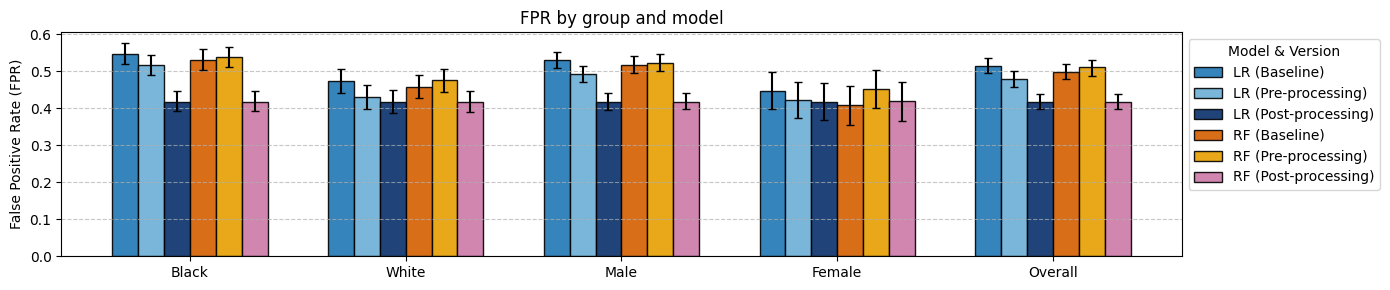

In [ ]:
# Flatten all summary tables and tag with version
base_df = summary_by_group_model_baseline.reset_index()
base_df['version'] = 'Baseline'

pre_df = summary_by_group_model_pre.reset_index()
pre_df['version'] = 'Pre-processing'

post_df = summary_by_group_model_post.reset_index()
post_df['version'] = 'Post-processing'

# Combine all into one DataFrame
combined_df = pd.concat([base_df, pre_df, post_df], ignore_index=True)

# Define plotting structure
groups = combined_df['group'].unique()
models = ['LR', 'RF']
versions = ['Baseline', 'Pre-processing', 'Post-processing']

# Bar settings
x = np.arange(len(groups))
total_bars = len(models) * len(versions)
width = 0.12  # narrow for 6 bars per group

# Setup figure
fig, ax = plt.subplots(figsize=(14, 3))

# Color map
color_map = {
    ('LR', 'Baseline'): '#1f77b4',
    ('LR', 'Pre-processing'): '#6baed6',
    ('LR', 'Post-processing'): '#08306b',
    ('RF', 'Baseline'): '#D55E00',
    ('RF', 'Pre-processing'): '#E69F00',
    ('RF', 'Post-processing'): '#CC79A7',
}

# Confidence interval map
ci_map = {
    'Baseline': confidence_intervals_baseline,
    'Pre-processing': confidence_intervals_pre,
    'Post-processing': confidence_intervals_post,
}

# Plot loop
for i_model, model in enumerate(models):
    for i_version, version in enumerate(versions):
        offset = (i_model * len(versions) + i_version - total_bars / 2 + 0.5) * width
        means = []
        lower_err = []
        upper_err = []

        for group in groups:
            row = combined_df[
                (combined_df['model'] == model) &
                (combined_df['group'] == group) &
                (combined_df['version'] == version)
            ]

            fpr_mean = row['fpr'].values[0]
            ci_lower, ci_upper = ci_map[version][(model, group)]['fpr']
            means.append(fpr_mean)
            lower_err.append(fpr_mean - ci_lower)
            upper_err.append(ci_upper - fpr_mean)

        ax.bar(
            x + offset,
            means,
            width,
            label=f'{model} ({version})',
            color=color_map[(model, version)],
            yerr=[lower_err, upper_err],
            capsize=3,
            edgecolor='black',
            alpha=0.9
        )

# Formatting
ax.set_ylabel('False Positive Rate (FPR)')
ax.set_title('FPR by group and model')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend(title='Model & Version', bbox_to_anchor=(1, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

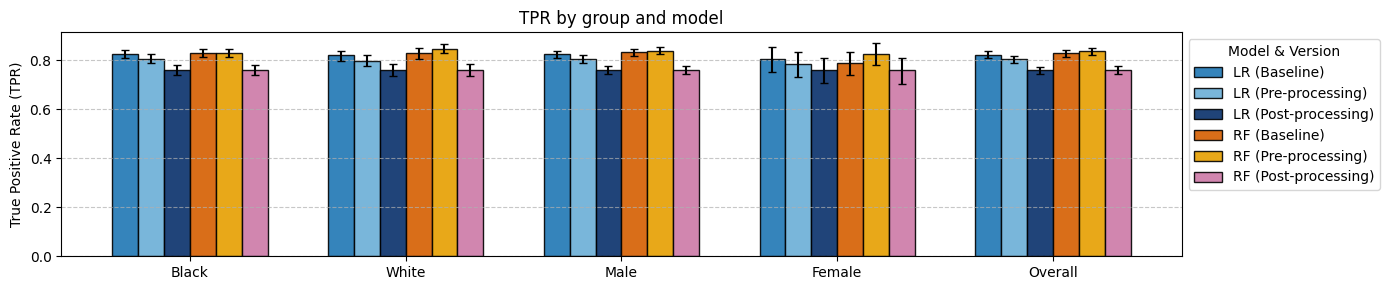

In [ ]:
fig, ax = plt.subplots(figsize=(14, 3))

# Plot each bar with TPR
for i_model, model in enumerate(models):
    for i_version, version in enumerate(versions):
        offset = (i_model * len(versions) + i_version - total_bars / 2 + 0.5) * width
        means = []
        lower_err = []
        upper_err = []

        for group in groups:
            row = combined_df[
                (combined_df['model'] == model) &
                (combined_df['group'] == group) &
                (combined_df['version'] == version)
            ]

            tpr_mean = row['tpr'].values[0]
            ci_lower, ci_upper = ci_map[version][(model, group)]['tpr']
            means.append(tpr_mean)
            lower_err.append(tpr_mean - ci_lower)
            upper_err.append(ci_upper - tpr_mean)

        ax.bar(
            x + offset,
            means,
            width,
            label=f'{model} ({version})',
            color=color_map[(model, version)],
            yerr=[lower_err, upper_err],
            capsize=3,
            edgecolor='black',
            alpha=0.9
        )

# Formatting
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('TPR by group and model')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend(title='Model & Version', bbox_to_anchor=(1, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Confusion matrices

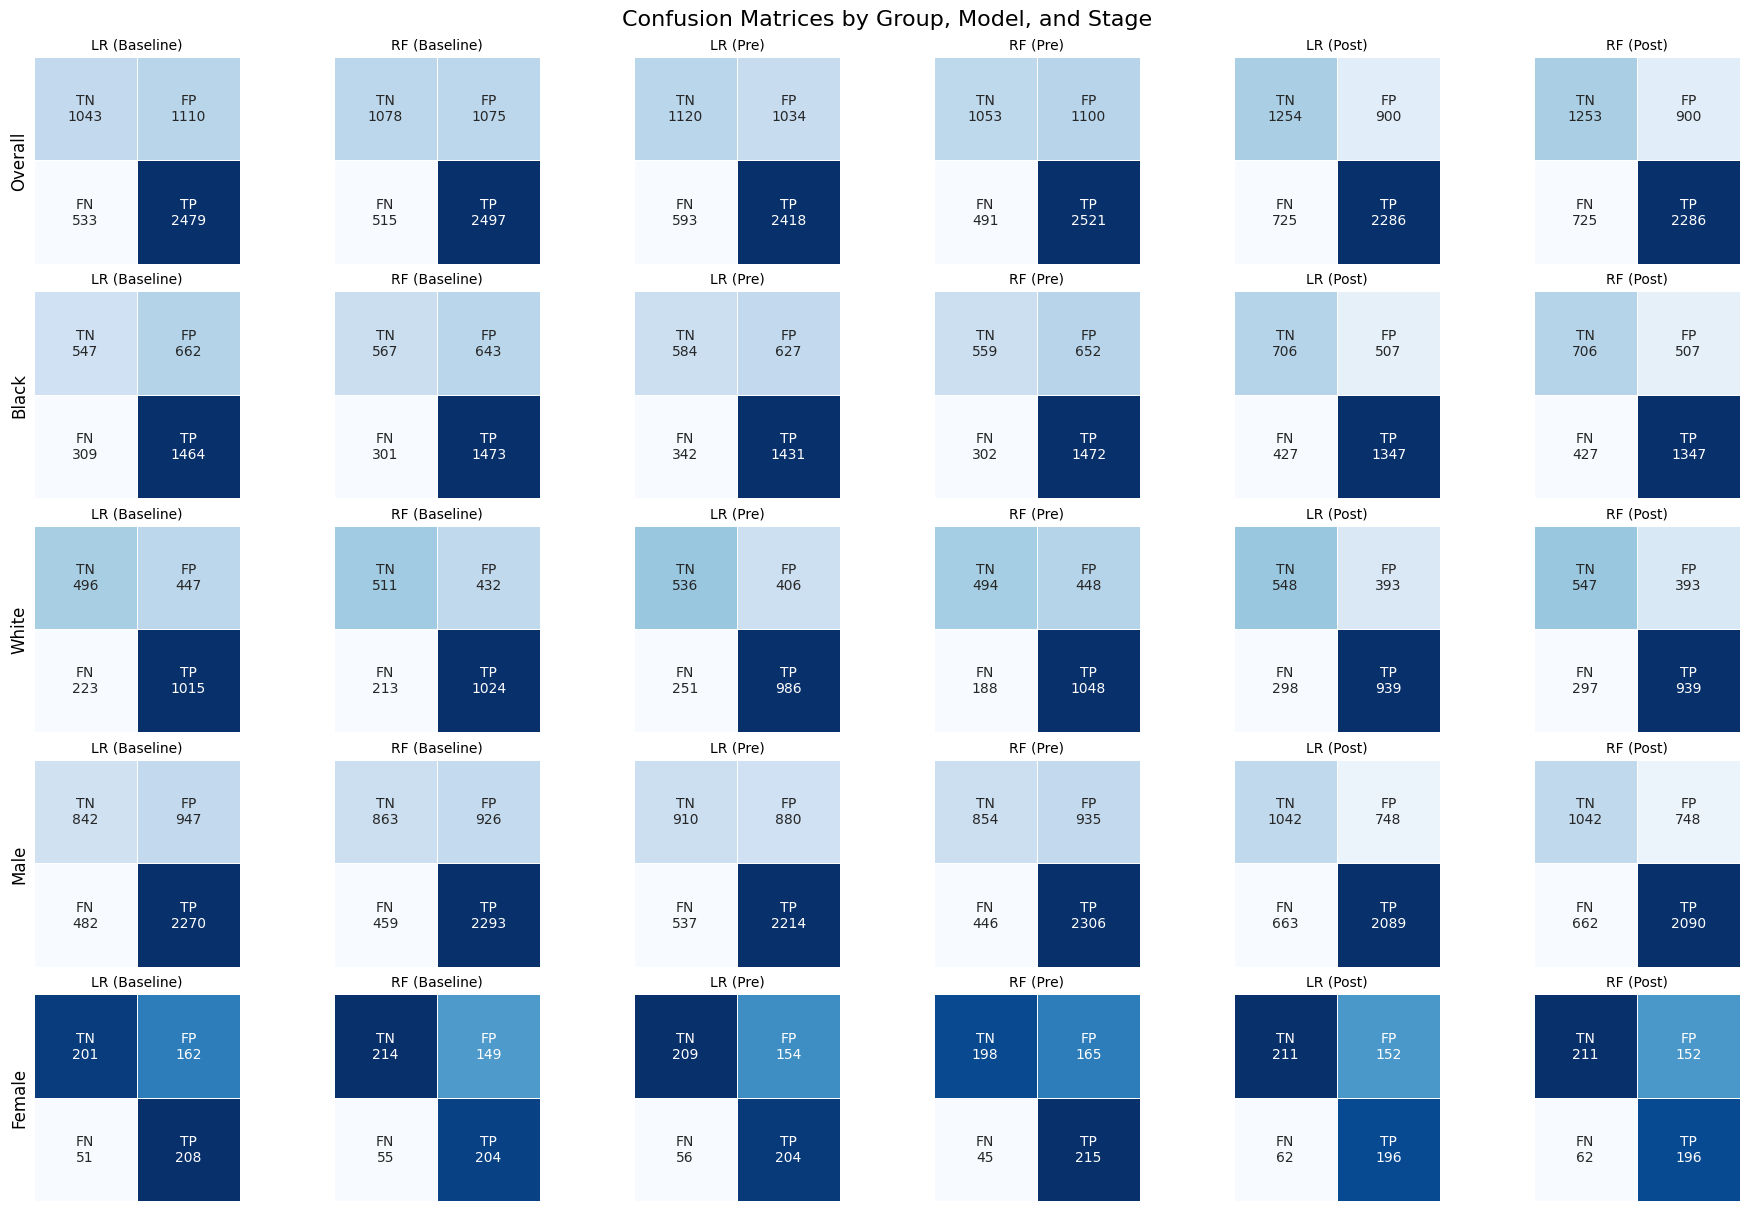

In [ ]:
# Collect all stages
summary_data_dict = {
    'Baseline': summary_by_group_model_baseline,
    'Pre': summary_by_group_model_pre,
    'Post': summary_by_group_model_post
}

groups = ['Overall', 'Black', 'White', 'Male', 'Female']
models = ['LR', 'RF']
stages = ['Baseline', 'Pre', 'Post']

fig, axes = plt.subplots(
    nrows=len(groups),
    ncols=len(models) * len(stages),
    figsize=(18, 12),
    constrained_layout=True
)

# Loop over all combinations
for row_idx, group in enumerate(groups):
    for col_idx, stage in enumerate(stages):
        for model_idx, model in enumerate(models):
            col_pos = col_idx * len(models) + model_idx

            ax = axes[row_idx, col_pos]
            summary_df = summary_data_dict[stage]

            # Fetch confusion matrix values
            try:
                row = summary_df.loc[(model, group)]
                tp = row['tp']
                fp = row['fp']
                tn = row['tn']
                fn = row['fn']
            except KeyError:
                ax.axis('off')
                continue

            cm = np.array([[tn, fp], [fn, tp]])
            labels = np.array([['TN', 'FP'], ['FN', 'TP']])

            # Heatmap
            sns.heatmap(
                cm,
                annot=labels + "\n" + cm.astype(int).astype(str),
                fmt='',
                cmap='Blues',
                cbar=False,
                ax=ax,
                annot_kws={"size": 10},
                linewidths=0.5,
                square=True
            )

            # Titles
            ax.set_title(f'{model} ({stage})', fontsize=10)
            if col_pos == 0:
                ax.set_ylabel(group, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

# Overall title
plt.suptitle("Confusion Matrices by Group, Model, and Stage", fontsize=16)
plt.show()


## Blackstonian ratio

In [ ]:
# Define function to compute TP/FP ratios for a given model
def compute_tp_fp_ratio(model_name, summaries, stage_names):
    data = {}
    for summary_df, stage in zip(summaries, stage_names):
        # Select only rows for the given model
        model_df = summary_df.loc[model_name]
        tp_fp = (model_df['tp'] / model_df['fp']).rename(stage)
        data[stage] = tp_fp

    # Combine into one DataFrame
    result = pd.concat(data.values(), axis=1)
    result.columns = stage_names
    return result

In [49]:
# Summary list and labels
summaries = [
    summary_by_group_model_baseline,
    summary_by_group_model_pre,
    summary_by_group_model_post
]
stage_names = ['Baseline', 'Pre', 'Post']

# Generate tables
tp_fp_LR = compute_tp_fp_ratio('LR', summaries, stage_names)
tp_fp_RF = compute_tp_fp_ratio('RF', summaries, stage_names)

# Display tables
print("Blackstone ratios for LR:")
print(tp_fp_LR)

print("\nBlackste ratios for RF:")
print(tp_fp_RF)


Blackstone ratios for LR:
         Baseline       Pre      Post
group                                
Black    2.209819  2.282111  2.655250
White    2.272616  2.425762  2.389587
Male     2.399928  2.516066  2.792392
Female   1.279074  1.325473  1.294033
Overall  2.235077  2.338613  2.539294

Blackste ratios for RF:
         Baseline       Pre      Post
group                                
Black    2.291120  2.256817  2.655389
White    2.372483  2.338401  2.387251
Male     2.477535  2.463832  2.791572
Female   1.371140  1.304508  1.292032
Overall  2.323786  2.290056  2.538257
